# Imports and setup

In [1]:
from IPython.display import display, HTML
from IPython.display import clear_output
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import col,lit
import pandas
display(HTML("<style>div.output_scroll { height: 80em; }</style>"))

# Analysis

#### The dataset analysed is 42.19 GB and contains all reddit comments from 2006-01 until 2010-12

In [2]:
### don't mess with this! ###
driverIP = !(hostname -I)
driverIP = driverIP[0].strip() # ip adress of the container running this app, needed for Spark to work

# note that default memory per executor is 1 GB, so we need to explicitly raise it to use full capacity of nodes
spark_session = SparkSession.builder\
.master("spark://sparknet:7077") \
.config("spark.driver.bindAdress","0.0.0.0")\
.config("spark.driver.host",f"{driverIP}")\
.config("spark.driver.port","8900")\
.config("spark.executor.memory", "14g")\
.appName("test_analysis")\
.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/21 13:41:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# this can be slow due to high network traffic from not running spark workers and hadoop datanodes in the same containers.
# (although inside a datacenter the network latency should not have a massive performance impact
# compared to the time it already takes to read from disk... At least if using HDD storage.)
df=spark_session.read.json("hdfs://hadoopnet:9000/user/root/reddit-comments")

In [4]:
print("Overall object count: "+str(df.count()))
df.printSchema()

Overall object count: 77475505
root
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- downs: long (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- removal_reason: string (nullable = true)
 |-- retrieved_on: long (nullable = true)
 |-- score: long (nullable = true)
 |-- score_hidden: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- ups: long (nullable = true)



In [5]:
# dropping unneccessary data elements
# df = df.drop('archived','controversiality','author_flair_css_class', 'author_flair_text', 'distinguished', 'downs', 'edited', 'gilded', 'id', 'link_id', 'parent_id', 'removal_reason', 'retrieved_on', 'score', 'score_hidden', 'stickied', 'subreddit', 'subreddit_id', 'ups')
# note that the above is equivalent to:
df = df.select('author','body','created_utc','name')
df.printSchema()

root
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- name: string (nullable = true)



In [6]:
df.show()

+----------------+--------------------+-----------+----+
|          author|                body|created_utc|name|
+----------------+--------------------+-----------+----+
|            jh99|early 2006 a prob...| 1136074029|null|
|             jpb|If you are going ...| 1136076410|null|
|       Pichu0102|Microsoft hates i...| 1136078623|null|
|        libertas|this looks intere...| 1136079346|null|
|        mdmurray|I have nothing bu...| 1136081389|null|
|        mdmurray|And by "Microsoft...| 1136081817|null|
|        mattknox|This is exactly t...| 1136083021|null|
|       [deleted]|           [deleted]| 1136088395|null|
|           sempf|Because this one ...| 1136088601|null|
|          dayuii|                  ok| 1136090694|null|
|         dfranke|I'm looking forwa...| 1136091198|null|
|           jcage|I hope not. I'm n...| 1136095018|null|
|TheCookieMonster|The opinionnaire ...| 1136096636|null|
|           scott|            awesome.| 1136099905|null|
|          stesch|But Caucho me

In [7]:
#Convert epoch to date and group by 
date = df.withColumn("timestamp",f.to_timestamp(df['created_utc'].cast('long')))
date.show()

+----------------+--------------------+-----------+----+-------------------+
|          author|                body|created_utc|name|          timestamp|
+----------------+--------------------+-----------+----+-------------------+
|            jh99|early 2006 a prob...| 1136074029|null|2006-01-01 00:07:09|
|             jpb|If you are going ...| 1136076410|null|2006-01-01 00:46:50|
|       Pichu0102|Microsoft hates i...| 1136078623|null|2006-01-01 01:23:43|
|        libertas|this looks intere...| 1136079346|null|2006-01-01 01:35:46|
|        mdmurray|I have nothing bu...| 1136081389|null|2006-01-01 02:09:49|
|        mdmurray|And by "Microsoft...| 1136081817|null|2006-01-01 02:16:57|
|        mattknox|This is exactly t...| 1136083021|null|2006-01-01 02:37:01|
|       [deleted]|           [deleted]| 1136088395|null|2006-01-01 04:06:35|
|           sempf|Because this one ...| 1136088601|null|2006-01-01 04:10:01|
|          dayuii|                  ok| 1136090694|null|2006-01-01 04:44:54|

### First we look at how user activity (in form of new comments) varies over time

#### The variation inside a day tells us something about which hours are most or least active. This information could also give us a clue about how global the user-base is, as a mostly local (for example, American) user base could be expected to lead to greater variation within a day. 

<Axes: title={'center': 'Distribution of all reddit post from 2006-01 to 2010-12 inside a day by hours'}, xlabel='Time', ylabel='Number of new comments'>

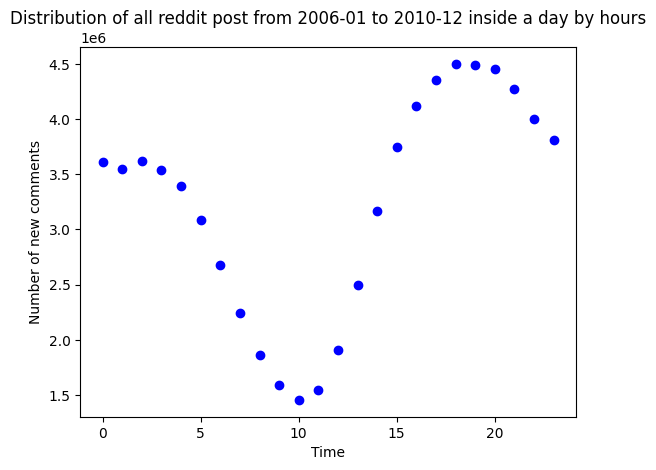

In [8]:
# Interactive code, not used in this run
#print("Give one of the following: \"hour\", \"day\", \"month\", \"year\"")
#name=input()
#while name not in ["hour", "day", "month", "year"]:
#    clear_output(wait=False)
#    print("Give one of the following: \"hour\", \"day\", \"month\", \"year\"")
#    name=input()
#
#if name=="hour":
#    func=f.hour
#    form='yyyy-MM-dd HH'
#    session='day by hours'
#    si=1
#elif name=="day":
#    func=f.dayofmonth
#    form='yyyy-MM-dd'
#    session='month by days'
#    si=3
#elif name=="month":
#    func=f.month
#    form='yyyy-MM'
#    session='year by month'
#    si=5
#elif name=="year":
#    func=f.year
#    form='yyyy'
#    session="period of years"
#    si=10

## distribution of comments inside a day
name = 'hour'
func=f.hour
form='yyyy-MM-dd HH'
session='day by hours'

clear_output(wait=False)
df2=date.groupBy(func("timestamp").alias(name)).count()
d=df2.toPandas()
d.sort_values(by=name)
d.plot(x=name, y='count', style='bo', title="Distribution of all reddit post from 2006-01 to 2010-12 inside a "+session, xlabel="Time", ylabel="Number of new comments", legend=False)



#### Looking at the number of new comments each month (mainly how it has changed over time) gives a good indication of the growth of the platform:

<Axes: title={'center': 'Comments per month from 2006-01 to 2010-12'}, xlabel='Time', ylabel='New comments'>

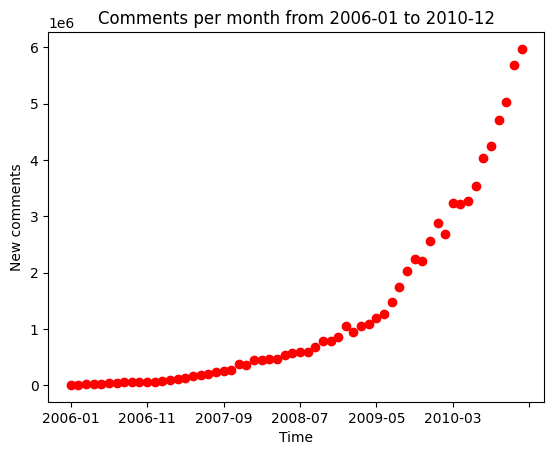

In [9]:
## Number of new comments per month 
form='yyyy-MM'
name='month'
df2=date.select(f.date_format('timestamp',form).alias(name)).groupby(name).count()
d=df2.toPandas()
d=d.sort_values(by='month')
d.plot(x=name, y='count', style='ro', title="Comments per month from 2006-01 to 2010-12", xlabel="Time", ylabel="New comments", legend=False)

#### In the following analysis we look at the usage frequency of a keyword over time:

<Axes: title={'center': 'Number of occurences of the word: subprime \n in new comments by month 2006-01 to 2010-12'}, xlabel='Time', ylabel='Number of new occurances'>

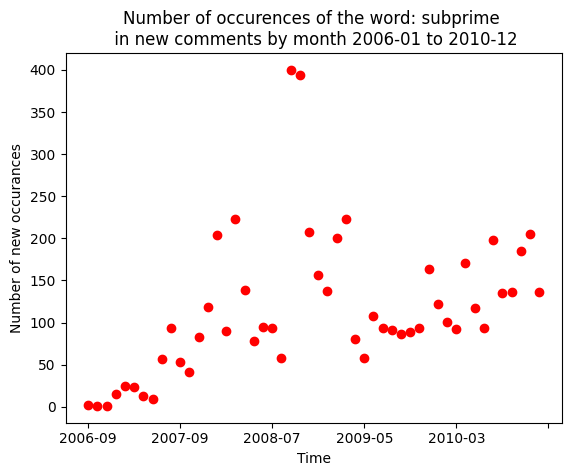

In [10]:
## Getting words separated, get rid of special characters and convert to lowercase for analysis

df3=date.withColumn("body", f.regexp_replace(date.body, "[^a-zA-Z0-9]", " "));
raw_words=df3.withColumn('body',f.explode(f.split('body',' ')))
words = raw_words.withColumn('body', f.lower(f.trim(raw_words.body)))

# We do not use the interactive functionality in this run
# Read searched word and filter data for it
#print("Give the searched key word:")
#word=str.lower(input())
word = 'subprime'
dff=words.filter(words.body==word)


# We do not use the interactive functionality in this run
#print("Give one of the following: \"hour\", \"day\", \"month\", \"year\"")
#name=input()
#while name not in ["hour", "day", "month", "year"]:
#    clear_output(wait=False)
#    print("Give one of the following: \"hour\", \"day\", \"month\", \"year\"")
#    name=input()
#
#if name=="hour":
#    func=f.hour
#    form='yyyy-MM-dd HH'
#    session='day by hours'
#    si=1
#elif name=="day":
#    func=f.dayofmonth
#    form='yyyy-MM-dd'
#    session='month by days'
#    si=3
#elif name=="month":
#    func=f.month
#    form='yyyy-MM'
#    session='year by month'
#    si=5
#elif name=="year":
#    func=f.year
#    form='yyyy'
#    session="period of years"
#    si=10

name='month'
form='yyyy-MM'
func=f.year

df2=dff.select(f.date_format('timestamp',form).alias(name)).groupby(name).count()
d=df2.toPandas()
d=d.sort_values(by=name)
d.plot(x=name, y='count', style='ro', title="Number of occurences of the word: "+word+" \n in new comments by month 2006-01 to 2010-12", xlabel="Time", ylabel="Number of new occurances", legend=False)

# Compute and plot distribution of comments across users

#### By computing the cumulative distribution function (CDF) of all comments across the user base, we can answer questions of the type "what percentage of users are responsible for 80% of the comments?" and similar. This allows us to assess the structure of the userbase and how user activity and total number of users are related. The method is inspired by those used to measure and illustrate wealth distributions in economics (which are usually summarized in form of Gini coefficients).

In [11]:
df5=(df.where("author <> '[deleted]'")).groupBy(df.author).count() 
top10=df5.sort(col('count').desc()).toPandas()
df6=df5.groupBy(df5['count'].alias('nr_post')).count()
pand=df6.toPandas()

80% of reddit comments come from 0.1897154161935366% of users.


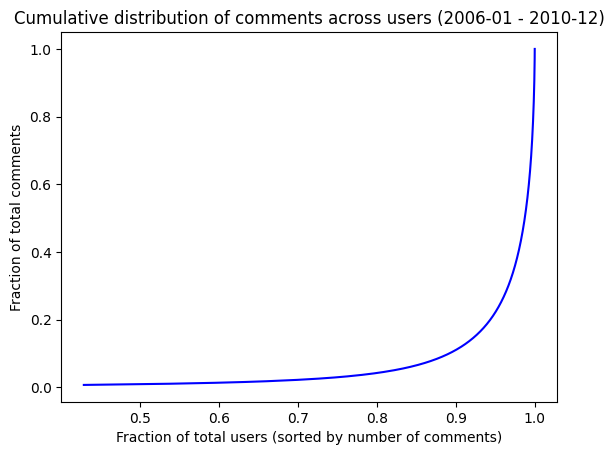

In [12]:
pand=pand.sort_values(by='nr_post')
pand['count_post']=pand['nr_post']*pand['count']
cdf=pandas.DataFrame()
cdf['nr_people']=pand['count'].cumsum()
cdf['count_post']=pand['count_post'].cumsum()
cdf['nr_people']=cdf['nr_people']*(1/cdf['nr_people'].max())
cdf['count_post']=cdf['count_post']*(1/cdf['count_post'].max())
cdf.plot(x='nr_people', y='count_post', style='-b', title="Cumulative distribution of comments across users (2006-01 - 2010-12)", xlabel="Fraction of total users (sorted by number of comments)", ylabel="Fraction of total comments", legend=False)
print("80% of reddit comments come from "+str(100*(1-cdf.loc[cdf['count_post']>0.8]['nr_people'].min()))+"% of users.")

In [13]:
top10=top10.head(10)
print("TOP 10 authors and the number of comments they've made (2006-01 - 2010-12):")
top10

TOP 10 authors and the number of comments they've made (2006-01 - 2010-12):


,author,count
0,NoMoreNicksLeft,55059
1,malcontent,46373
2,matts2,43885
3,insomniac84,39802
4,AMerrickanGirl,32973
5,AnnArchist,32398
6,IConrad,30494
7,andrewsmith1986,29286
8,mexicodoug,28870
9,mutatron,28735


In [ ]:
spark_session.stop()